# **💁🏻🗨️💁🏻‍♂️안개 예측 EDA code**
> **안개량 예측** 경진대회에 오신 여러분 환영합니다! 🎉    
> 본 대회에서는 최대 10명이 참여할 수 있는 기상청 주관 날씨 빅데이터 경진대회 입니다.     
> 주어진 데이터를 활용하여 안개 상태의 구간을 예측할 수 있는 모델을 만드는 것이 목표입니다!

# Contents  
  
- 필요한 라이브러리 설치  
- 데이터 불러오기  
- 데이터 결측치 및 기본정보 파악하기  
- 변수간의 관계 및 인사이트 발굴 EDA  

### 1. 필요한 라이브러리 설치

- 필요한 라이브러리를 설치한 후 불러옵니다.

In [2]:
# basic
import os, random
import pandas as pd
import numpy as np

# graph
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 폰트
plt.rcParams['font.family'] = 'NanumSquare'

# 마이너스 출력
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
# random seed 고정하기
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

### 2. 데이터 불러오기
- 제공된 데이터를 불러옵니다.

> - year : 년도
> - month : 월
> - day : 일
> - hour : 시간
> - minute : 분(10분 단위)
> - stn_id : 지점 번호
> - ws10_deg : 10분 평균 풍향, deg
> - ws10_ms : 10분 평균 풍속, m/s
> - ta : 1분 평균 기온 10분 주기, 섭씨
> - re : 강수 유무 0:무강수, 1:강수
> - hm : 1분 평균 상대 습도 10분 주기, %
> - sun10 : 1분 일사량 10분 단위 합계, MJ
> - ts : 1분 평균 지면온도 10분 주기, 섭씨

- test 없는 데이터 값
> - vis1 : 1분 평균 시정 10분 주기, m
> - class : 시정 구간

시정 구간은 다음과 같다.
- 0초과 200미만 : 1
- 200이상 500미만 : 2
- 500이상 1000미만 : 3
- 1000이상 : 4
- 4번은 맞춰도 스코어가 증가하진 않지만 틀리면 감점

In [4]:
# load data
train = pd.read_csv('../data/fog_train.csv')
train_final = pd.read_csv('../data/train_final_preprocess.csv')
test = pd.read_csv('../data/fog_test.csv')
test_final = pd.read_csv('../data/train_final_preprocess.csv')

In [5]:
# 쓸데없는 열 제거
train.drop(['Unnamed: 0'], axis = 1, inplace = True)
test.drop(['Unnamed: 0'], axis = 1, inplace = True)


### 3. 데이터 결측치 및 기본정보 파악하기

In [6]:
# 결측치 nan으로 바꾸기
train2 = train.replace(-99, np.nan).replace(-99.9, np.nan).replace(-999.0, np.nan)
test2 = test.replace(-99, np.nan).replace(-99.9, np.nan).replace(-999.0, np.nan)

In [7]:
# 변수 이름 앞에있는 이상한거 제거하기
train2.columns = train2.columns.str.replace('fog_train.', '')
test2.columns = test2.columns.str.replace('fog_test.', '')

In [8]:
train2.shape

(3156459, 15)

In [9]:
test2.shape

(262800, 14)

In [10]:
train2.describe()

,month,day,time,minute,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
count,3.156459e+06,3.156459e+06,3.156459e+06,3.156459e+06,3.150549e+06,3.150633e+06,3.152592e+06,3.141231e+06,3.152843e+06,3.112549e+06,3.067820e+06,3.133943e+06,3.133943e+06
mean,6.521931e+00,1.573276e+01,1.150007e+01,2.500016e+01,1.857501e+02,2.187844e+00,1.342696e+01,5.230975e-02,6.686834e+01,1.022780e-01,1.608666e+01,1.977727e+04,3.980869e+00
std,3.448969e+00,8.801320e+00,6.922149e+00,1.707819e+01,1.066048e+02,1.760316e+00,1.027291e+01,2.226510e-01,2.100344e+01,1.581698e-01,1.210345e+01,1.199038e+04,2.038098e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.430000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-4.900000e+00,1.000000e+00,1.000000e+00
25%,4.000000e+00,8.000000e+00,6.000000e+00,1.000000e+01,8.540000e+01,9.000000e-01,5.500000e+00,0.000000e+00,5.130000e+01,0.000000e+00,6.000000e+00,1.250000e+04,4.000000e+00
50%,7.000000e+00,1.600000e+01,1.200000e+01,3.000000e+01,2.098000e+02,1.800000e+00,1.430000e+01,0.000000e+00,6.870000e+01,0.000000e+00,1.630000e+01,2.000000e+04,4.000000e+00
75%,1.000000e+01,2.300000e+01,1.800000e+01,4.000000e+01,2.770000e+02,3.000000e+00,2.200000e+01,0.000000e+00,8.470000e+01,1.700000e-01,2.450000e+01,2.000000e+04,4.000000e+00
max,1.200000e+01,3.100000e+01,2.300000e+01,5.000000e+01,3.600000e+02,2.250000e+01,3.780000e+01,1.000000e+00,1.000000e+02,2.687000e+01,7.010000e+01,6.052500e+04,4.000000e+00


In [11]:
train2.isna().sum()

year            0
month           0
day             0
time            0
minute          0
stn_id          0
ws10_deg     5910
ws10_ms      5826
ta           3867
re          15228
hm           3616
sun10       43910
ts          88639
vis1        22516
class       22516
dtype: int64

In [12]:
# 상혁 - class와 vis1의 관계에 대해 이상치가 있는지 확인
train2[(train2['class'] != 4) & (train2['vis1'] > 1000)]

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class


- 이상치로 판단될 수 있는 값이 한건도 존재하지 않았다.

### 4. EDA

- STN_ID가 각각 내륙, 해안, 산간지방의 일부 지역을 발췌한것이다. 따라서 지역에 따라 안개 생성 형태가 다를 수 있으므로 어떤 형태인지 대략적으로 찾아본다.

In [13]:
# 내륙, 내륙산간, 동해, 서해, 남해
train2['ground'] = train2['stn_id'].str.slice(0, 1)

In [14]:
# 지역별 수치 월평균 계산
train_ground_sum = train2[train2['class'] != 4].groupby(['stn_id', 'month']).mean().reset_index()

In [15]:
train_ground_sum

,stn_id,month,day,time,minute,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
0,AA,1,17.309524,11.547619,26.190476,141.190000,2.225000,0.877500,0.475000,85.067500,0.017381,0.170000,675.875000,2.781250
1,AA,2,12.463415,11.658537,23.170732,232.160000,2.247500,2.835000,0.325000,78.170000,0.029500,2.260000,666.562500,2.687500
2,AA,3,24.619048,13.619048,26.904762,235.513514,2.559459,15.124324,0.108108,47.975676,0.097179,13.105405,828.222222,2.888889
3,AA,4,19.465517,12.431034,22.758621,228.050980,4.901961,11.506000,0.098039,46.904000,0.313774,21.033333,652.714286,2.571429
4,AA,5,17.453333,11.186667,27.333333,201.125000,1.879412,16.142647,0.304348,74.102941,0.042778,16.548529,534.260870,2.304348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,EC,8,22.645455,8.400000,23.090909,151.497273,2.735455,24.516364,0.327273,94.787273,0.020182,25.093636,430.906250,2.114583
236,EC,9,10.428571,9.952381,25.952381,74.190244,11.070732,24.426829,0.780488,90.126829,0.032683,24.663415,558.468750,2.468750
237,EC,10,9.941176,12.941176,22.352941,255.917647,5.670588,19.964706,0.235294,67.658824,0.103529,22.017647,629.333333,2.666667
238,EC,11,19.974359,10.756410,24.102564,223.905128,4.360256,9.782051,0.064103,60.670513,0.042692,9.556410,442.166667,2.166667


In [16]:
# train 그래프 확인해보기
for col in ['ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts', 'vis1', 'class']:
    # ground별 지면에 따른 유형 확인
    fig = px.line(train_ground_sum,
                  x="month",
                  y=col,
                  color='stn_id',
                  markers=True)

    fig.update_layout(title_text="ground에 따른 데이터 형태",
                      title_x = 0.5,
                      title_xanchor = 'center',
                      title_font_size = 25,
                      title_font_color = 'black',
                      title_font_family = 'NanumSquare',
                      plot_bgcolor='#ffffff')

    fig.update_traces(# marker_color = 히스토그램 색, 
                     # marker_line_width = 히스토그램 테두리 두깨,                            
                     # marker_line_color = 히스토그램 테두리 색,
                     marker_opacity = 0.4,
                     )

    fig.show()

다음 페이지에서 안개에 대한 
- 주로 여름에 산간 지방 안개가 많이 생김
- 봄에는 주로 해안가
- 가을에는 주로 내륙지방에서 생긴다고 함

In [17]:
# 지역별 안개 발생 횟수
# fig = px.bar(train2,
#             x="class",
#             color="stn_id",
#             barmode="group")

# fig.update_layout(title_text="ground에 따른 데이터 형태",
#                     title_x = 0.5,
#                     title_xanchor = 'center',
#                     title_font_size = 25,
#                     title_font_color = 'black',
#                     title_font_family = 'NanumSquare',
#                     plot_bgcolor='#ffffff')

# fig.update_traces(# marker_color = 히스토그램 색, 
#                     # marker_line_width = 히스토그램 테두리 두깨,                            
#                     # marker_line_color = 히스토그램 테두리 색,
#                     marker_opacity = 0.4,
#                     )

# fig.show()

In [18]:
# class 불균형 확인
train2['class'].value_counts()

4.0    3101809
3.0      12180
2.0      12088
1.0       7866
Name: class, dtype: int64

In [19]:
# 지형 유형으로 
train2['ground'].value_counts()

A    1262584
B     631292
D     473469
E     473468
C     315646
Name: ground, dtype: int64

<AxesSubplot: xlabel='class', ylabel='count'>

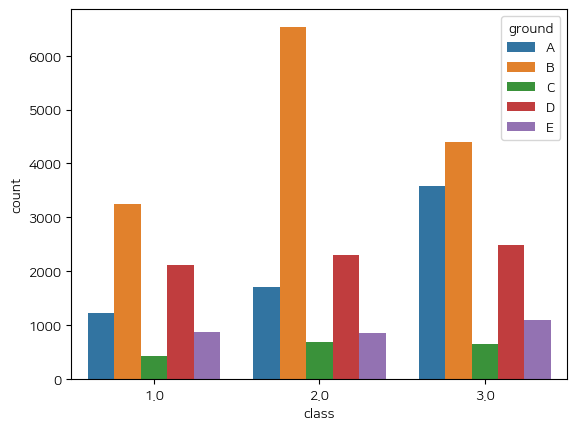

In [20]:
# 그라운드 유형별 그래프
sns.countplot(data = train2[train2['class'] != 4], x = 'class', hue = 'ground')

<AxesSubplot: xlabel='vis1', ylabel='Density'>

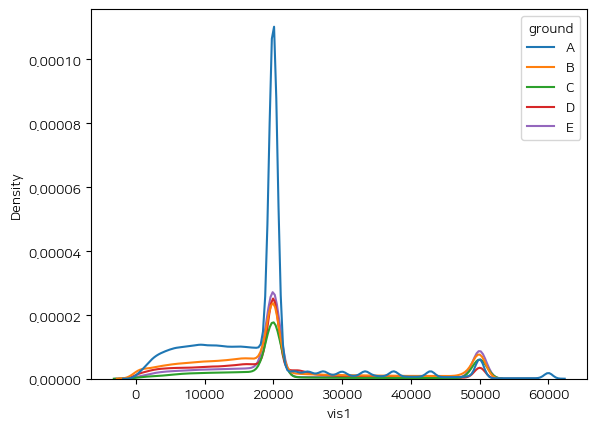

In [21]:
# 지역별 그래프 모형
sns.kdeplot(data = train2, x = 'vis1', hue = 'ground')

<AxesSubplot: xlabel='vis1', ylabel='Count'>

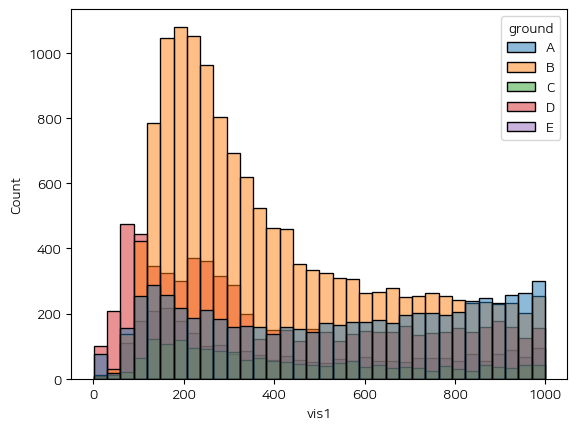

In [22]:
# 안개가 존재할 때만 고려
sns.histplot(data = train2[train2['class'] != 4], x = 'vis1', hue = 'ground')

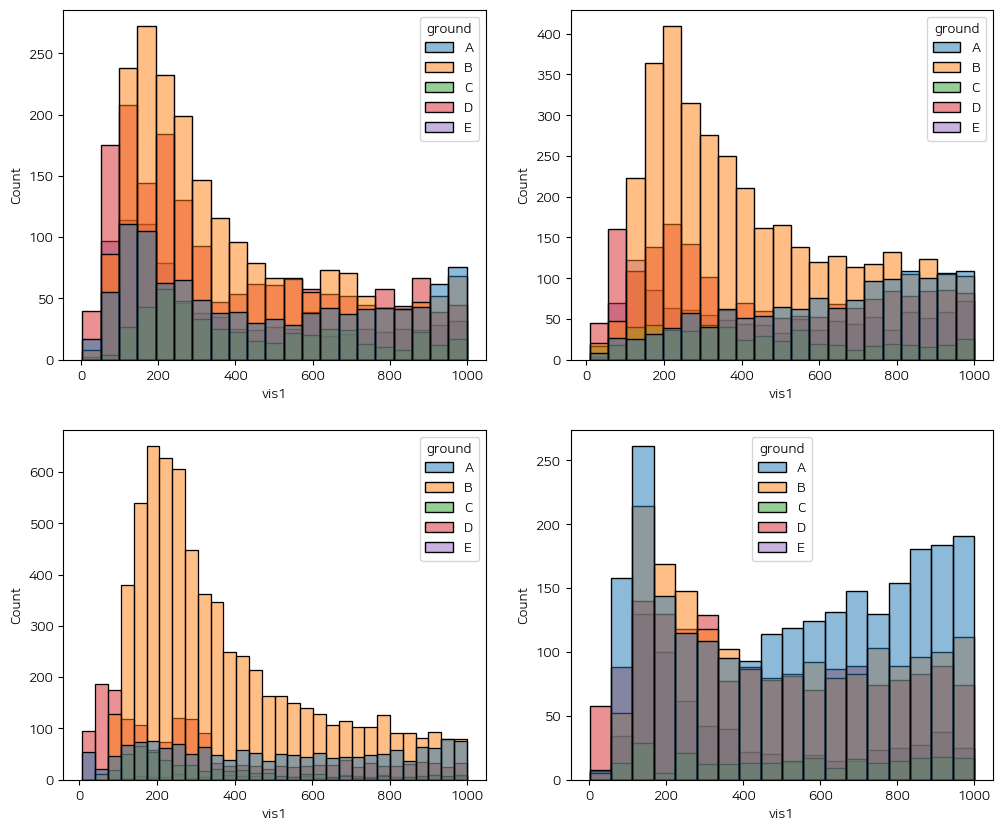

In [23]:
# 월별로 데이터 잘라서 보기
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

season = [[3, 4, 5], [6, 7, 8], [9, 10, 11], [12, 1, 2]]
sname = ['봄', '여름', '가을', '겨울']
i = 0
for r in range(2):
    for c in range(2):
        tmp = train2[(train2['class'] != 4) & (train2['month'].isin(season[i]))]
        axes[r][c] = sns.histplot(data = tmp, x = 'vis1', hue = 'ground', ax = axes[r][c])
        i += 1

- 한강 뿐만 아니라 낙동강 등 강가에 있는 내륙지방일 수도 있음
- 내륙으로 추정되는 A를 세부적으로 비교해볼 필요가 있음

<AxesSubplot: xlabel='vis1', ylabel='Density'>

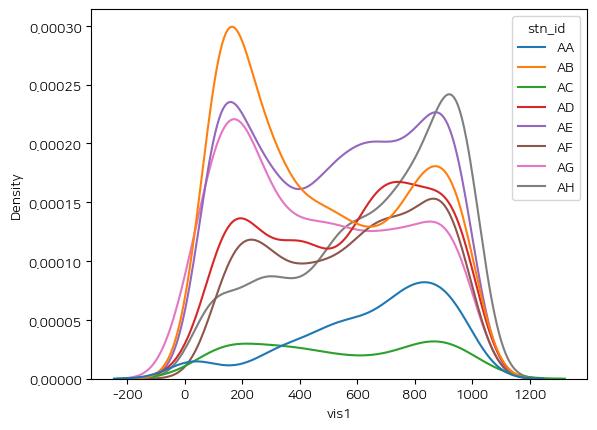

In [24]:
# 안개가 존재할 때만 고려 - vis1
sns.kdeplot(data = train2[(train2['class'] != 4) & (train2['ground'] == 'A')], x = 'vis1', hue = 'stn_id')

<AxesSubplot: xlabel='vis1', ylabel='Density'>

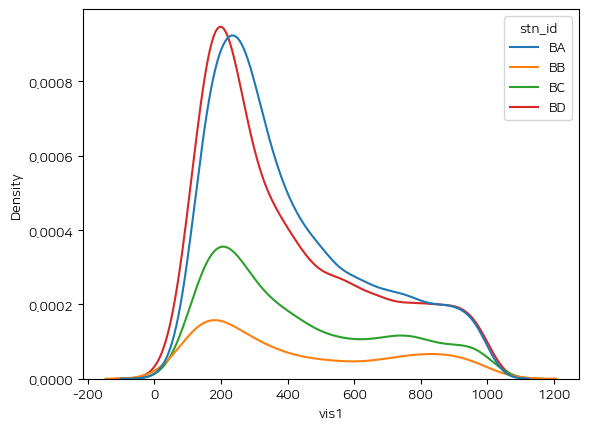

In [25]:
# 안개가 존재할 때만 고려 - vis1
sns.kdeplot(data = train2[(train2['class'] != 4) & (train2['ground'] == 'B')], x = 'vis1', hue = 'stn_id')

<AxesSubplot: xlabel='vis1', ylabel='Density'>

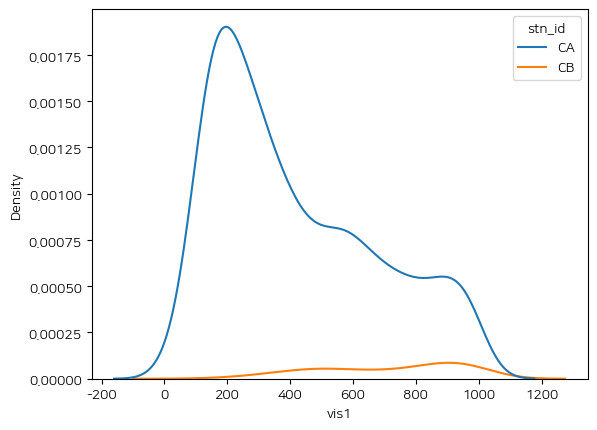

In [26]:
# 안개가 존재할 때만 고려 - vis1
sns.kdeplot(data = train2[(train2['class'] != 4) & (train2['ground'] == 'C')], x = 'vis1', hue = 'stn_id')

<AxesSubplot: xlabel='vis1', ylabel='Density'>

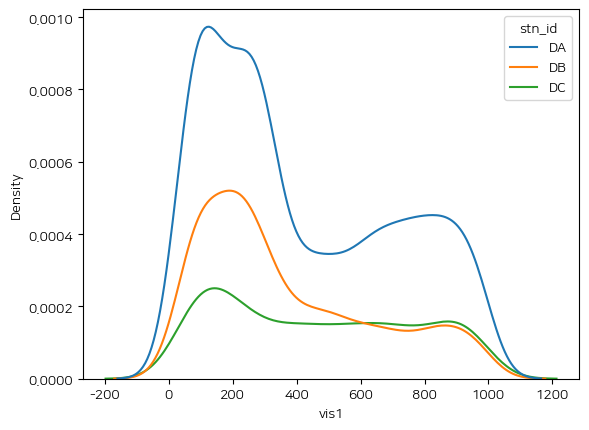

In [27]:
# 안개가 존재할 때만 고려 - vis1
sns.kdeplot(data = train2[(train2['class'] != 4) & (train2['ground'] == 'D')], x = 'vis1', hue = 'stn_id')

<AxesSubplot: xlabel='vis1', ylabel='Density'>

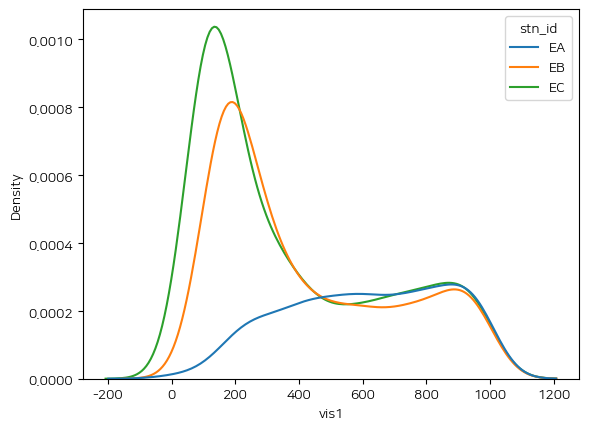

In [28]:
# 안개가 존재할 때만 고려 - vis1
sns.kdeplot(data = train2[(train2['class'] != 4) & (train2['ground'] == 'E')], x = 'vis1', hue = 'stn_id')

In [29]:
# 새로운 기준을 통해
tmp2 = train2[train2['vis1'] < 1000].groupby(['stn_id', 'month', 'class']).count()['vis1'].reset_index()

# 월별 일자의 개수로 나눠주기 위함
cri_month = train2.groupby('month').max().reset_index()[['month', 'day']]

# pd.merge
tmp3 = pd.merge(tmp2, cri_month, on = 'month')

# 평균값
tmp3['day'] = 6 * 24

tmp3

,stn_id,month,class,vis1,day
0,AA,1,1.0,1,144
1,AA,1,2.0,5,144
2,AA,1,3.0,26,144
3,AB,1,1.0,90,144
4,AB,1,2.0,49,144
...,...,...,...,...,...
630,EA,12,3.0,1,144
631,EB,12,1.0,86,144
632,EB,12,2.0,113,144
633,EB,12,3.0,43,144


In [30]:
# 내륙, 해안, 산간 지방에 따라 지역을 분류해보기 위해 그려보는 그래프
fig = px.bar(tmp2[tmp2['stn_id'] == 'AB'],
                  x="month",
                  y='vis1',
                  color='class')

fig.update_layout(title_text="보고싶은 데이터",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

<AxesSubplot: xlabel='month', ylabel='vis1'>

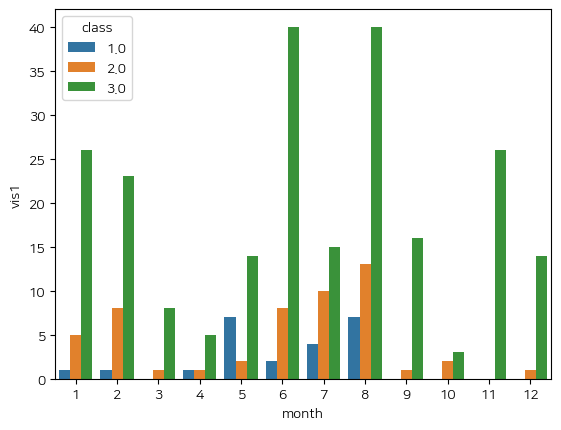

In [31]:
# A지역의 월별 정보
sns.barplot(data = tmp2[tmp2['stn_id']=='AA'], x = 'month', y = 'vis1', hue = 'class', ci = False, dodge = "overlay")

In [32]:
train2['day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

In [33]:
train2

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,ground
0,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000.0,4.0,A
1,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000.0,4.0,A
2,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000.0,4.0,A
3,I,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000.0,4.0,A
4,I,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000.0,4.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,K,12,31,23,10,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000.0,4.0,E
3156455,K,12,31,23,20,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000.0,4.0,E
3156456,K,12,31,23,30,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000.0,4.0,E
3156457,K,12,31,23,40,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000.0,4.0,E


In [34]:
test2['stn_id'].unique()

array(['AI', 'BE', 'CC', 'DD', 'ED'], dtype=object)

In [35]:
train2['stn_id'].unique()

array(['AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'BA', 'BB', 'BC',
       'BD', 'CA', 'CB', 'DA', 'DB', 'DC', 'EA', 'EB', 'EC'], dtype=object)

지역이 별로 상관없다는 것을 깨달았다.

그렇다면 어떤것이 지역처럼 나누는데 유의할까?

다음과 같은 관계를 통해 하나씩 파헤쳐 나가보자

- 상관관계 한번 조사해보기
- 시계열별 변화량 지켜보기

<AxesSubplot: >

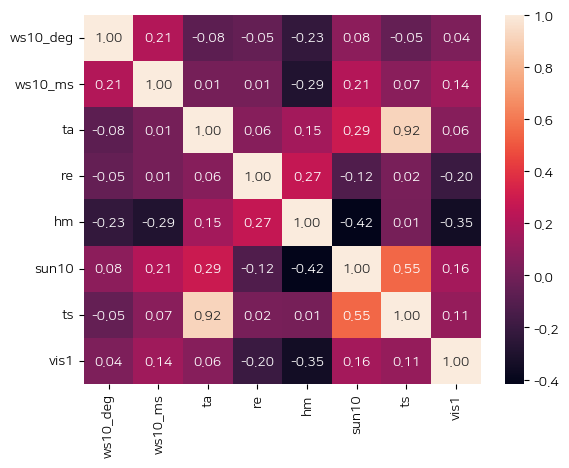

In [36]:
### 각 변수의 상관관계 조사해보자
# 1. 전체 변수에 대한 상관계수 조회 - 시간적 요인 제외
sns.heatmap(train2[['ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts', 'vis1']].corr(), annot = True, fmt = ".2f")

<AxesSubplot: >

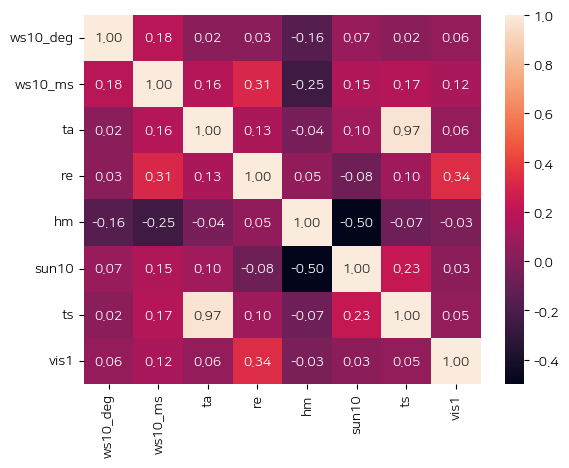

In [37]:
# 2. vis1 < 1000에 대한 상관계수 조회 - 시간적 요인 제외
sns.heatmap(train2[train2['vis1'] < 1000][['ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts', 'vis1']].corr(), annot = True, fmt = ".2f")

<AxesSubplot: >

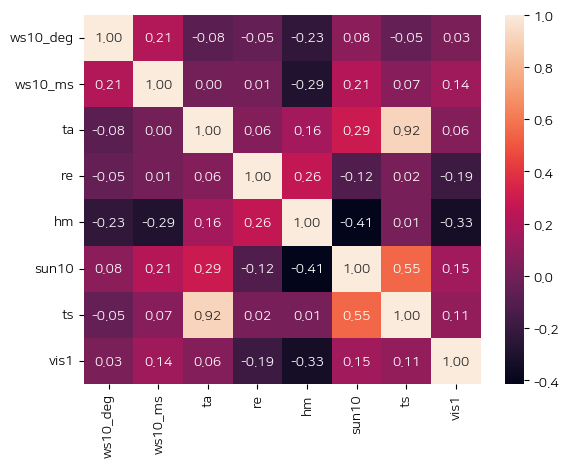

In [38]:
# 3. vis1 >= 1000에 대한 상관계수 조회 - 시간적 요인 제외
sns.heatmap(train2[train2['vis1'] >= 1000][['ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts', 'vis1']].corr(), annot = True, fmt = ".2f")

얻을 수 있었던 것?

- 1000거리 바깥으로 sun10과 관련이 있지만 1000거리 안쪽으로는 크게 관련이 없다.
- 즉, 우리가 알고싶은 범위 안에서 관련이 없다.

- 확실한것은 안개가 생기는 조건에 관해서 강수 여부가 가장 관련이 있다는것
- 안개 이외의 지역에서 확인해보면 습도가 적을수록 가시거리가 길어진다는 것

다음과 같은 인사이트를 활용할 수 있는 방안?

- 날이 흐린 지역에서 안개가 발생할 가능성이 높다: 연무일 가능성도 있어보이고 지역에 따라 안개가 많이 발생하는 지역일 수도 있다.
- 단순하게 변수 관계만 놓고 봤을 때는 그렇지만 분명 많은 요인을 조합하면 새로운 결과를 맞이할 수도 있다.

In [39]:
### 결측치가 존재하는 지역, 연도 확인
train2[(train2['vis1'].isna()) & (train2['stn_id'] == 'AA')]

# vis1, class 둘중 하나만 결측치인 경우는 없다.

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,ground
7645,I,2,23,2,20,AA,272.0,1.3,-0.9,0.0,61.1,0.00,-1.0,NaN,NaN,A
7780,I,2,24,0,50,AA,140.7,1.2,2.1,0.0,59.5,0.00,0.8,NaN,NaN,A
16053,I,4,21,11,40,AA,271.7,7.0,9.2,0.0,42.8,0.32,16.7,NaN,NaN,A
16054,I,4,21,11,50,AA,276.4,6.0,9.3,0.0,43.4,0.26,19.0,NaN,NaN,A
16055,I,4,21,12,0,AA,268.4,5.9,9.5,0.0,41.7,0.48,21.1,NaN,NaN,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2151888,K,11,20,19,30,AA,225.2,0.5,14.0,0.0,54.0,0.00,8.7,NaN,NaN,A
2152807,K,11,27,4,40,AA,31.7,2.4,-0.9,0.0,57.9,0.00,-0.3,NaN,NaN,A
2153798,K,12,4,1,50,AA,280.4,3.9,-1.9,0.0,58.9,0.00,-0.9,NaN,NaN,A
2155091,K,12,13,1,20,AA,244.7,2.1,2.7,0.0,78.3,0.00,0.3,NaN,NaN,A


In [40]:
# 구체적으로 날짜를 지정해 확인
train2[(train2['month'] == 5) & (train2['stn_id'] == 'CA') & (train2['day'] == 22)]

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,ground
652883,I,5,22,0,0,CA,140.1,1.9,12.7,0.0,82.7,0.0,13.8,1465.0,4.0,C
652884,I,5,22,0,10,CA,160.4,1.6,12.7,0.0,82.8,0.0,13.7,20000.0,4.0,C
652885,I,5,22,0,20,CA,158.1,1.2,12.7,0.0,82.9,0.0,13.6,20000.0,4.0,C
652886,I,5,22,0,30,CA,148.1,0.9,12.7,0.0,83.1,0.0,13.8,20000.0,4.0,C
652887,I,5,22,0,40,CA,149.4,1.1,12.7,0.0,83.4,0.0,13.7,18886.0,4.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756422,K,5,22,23,10,CA,220.1,0.4,17.3,0.0,71.2,0.0,15.6,25000.0,4.0,C
2756423,K,5,22,23,20,CA,262.7,0.2,17.2,0.0,70.5,0.0,15.4,27500.0,4.0,C
2756424,K,5,22,23,30,CA,242.7,0.4,17.1,0.0,71.1,0.0,15.3,28700.0,4.0,C
2756425,K,5,22,23,40,CA,0.0,0.0,17.0,0.0,72.5,0.0,15.3,30900.0,4.0,C


In [41]:
tmp00 = train2.groupby(['year', 'month', 'day', 'stn_id']).mean()

In [42]:
tmp01 = tmp00.groupby(['year', 'month', 'stn_id']).mean()['ta'].reset_index()

In [43]:
tmp01

,year,month,stn_id,ta
0,I,1,AA,1.631604
1,I,1,AB,-0.075727
2,I,1,AC,3.767158
3,I,1,AD,2.714465
4,I,1,AE,3.456614
...,...,...,...,...
715,K,12,DB,1.933714
716,K,12,DC,-1.934879
717,K,12,EA,3.255090
718,K,12,EB,0.228260


In [44]:
# 내륙, 해안, 산간 지방에 따라 지역을 분류해보기 위해 그려보는 그래프
fig = px.bar(tmp01,
                  x="month",
                  y='ta',
                  color='stn_id',
                  barmode="group")

fig.update_layout(title_text="월별 일교차 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [45]:
train2['stn_id'].value_counts()

AA    157823
AB    157823
EB    157823
EA    157823
DC    157823
DB    157823
DA    157823
CB    157823
CA    157823
BD    157823
BC    157823
BB    157823
BA    157823
AH    157823
AG    157823
AF    157823
AE    157823
AD    157823
AC    157823
EC    157822
Name: stn_id, dtype: int64

In [46]:
train2['minute'].value_counts()

10    526080
30    526080
40    526080
50    526080
20    526079
0     526060
Name: minute, dtype: int64

In [47]:
train2[(train2['stn_id'] == 'EC') & (train2['time'] == 18) & (train2['year'] == 'J') & (train2['month'] == 11) & (train2['day'] == 3)]

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,ground
2096872,J,11,3,18,0,EC,272.9,2.0,16.1,0.0,49.2,0.0,15.2,20000.0,4.0,E
2096873,J,11,3,18,10,EC,272.9,2.2,15.9,0.0,49.1,0.0,14.9,20000.0,4.0,E
2096874,J,11,3,18,30,EC,261.2,1.9,15.6,0.0,47.1,0.0,14.3,20000.0,4.0,E
2096875,J,11,3,18,40,EC,264.8,2.5,15.5,0.0,46.2,0.0,14.0,20000.0,4.0,E
2096876,J,11,3,18,50,EC,263.3,2.6,15.3,0.0,48.4,0.0,13.9,20000.0,4.0,E


#### 특수 케이스 찾아서 잘 맞춰주자
- 지역별로 하나씩 고루 보기
- I, J, K년도는 2020 ~ 2022년으로 만들어서 보자

In [48]:
# 시간
train2['hour'] = train2['time']

In [49]:
# I, J, K -> 2020 ~ 2022
cri = [
    train2['year'] == "I",
    train2['year'] == "J"
]
con = [
    2020,
    2021
]
train2['yeartmp'] = np.select(cri, con, default = 2022)

In [50]:
# year 값 바꾸기
train3 = train2.copy()
train3['year'] = train3['yeartmp']
train3.drop(['yeartmp'], axis = 1, inplace = True)

In [51]:
# 연, 월, 일, 시간, 분을 하나의 datetime 객체로 변환하고 문자열 형식으로 변환
train3['DateTime'] = pd.to_datetime(train3[['year', 'month', 'day', 'hour', 'minute']]).dt.strftime('%Y-%m-%d %H:%M')

In [52]:
# 내륙, 해안, 산간 지방에 따라 지역을 분류해보기 위해 그려보는 그래프
fig = px.line(train3[(train3['stn_id'] == 'AA') & (train3['year'] == 2020)],
                  x="DateTime",
                  y='vis1')

fig.update_layout(title_text="월별 일교차 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [53]:
# # 4의 위치를 기준으로 그룹 나누기
# groups = (train3['class'] == 4).cumsum()

# # 각 그룹별로 4가 아닌 값의 누적합 계산
# train3['cumulative_count'] = train3['class'].ne(4).groupby(groups).cumsum()

In [54]:
# # 한칸씩 밑으로 이동
# train3['lag'] = train3['cumulative_count'].shift(1)

# # 이전값과 현재 누적 카운트 빼기
# train3['diff'] = train3['cumulative_count'] - train3['lag']

In [55]:
# train3[train3['diff'] < 0]['diff'].value_counts()

In [56]:
# 지역별로 잘라서 이상치 -> 결측치 만들기
train4 = train3[train3['stn_id'] == 'AA']

In [57]:
# lag 만들어서 지난번  class 확인하기
train4['shift_class'] = train4['class'].shift(1)

# 이전과의 차이 구하기
train4['diff_class'] = train4['class'] - train4['shift_class']

# lag 만들어서 이다음 class 확인하기
train4['shift_right_class'] = train4['class'].shift(-1)

# 이다음과의 차이 구하기
train4['diff_right_class'] = train4['class'] - train4['shift_right_class']

In [58]:
idx = train4[(abs(train4['diff_class']) >= 2) & (abs(train4['diff_right_class']) >= 2)].index

In [59]:
train3.iloc[idx, :]['class'] = np.nan
train3.iloc[idx, :]['vis1'] = np.nan

In [60]:
train2

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,ground,hour,yeartmp
0,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000.0,4.0,A,0,2020
1,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000.0,4.0,A,0,2020
2,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000.0,4.0,A,0,2020
3,I,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000.0,4.0,A,0,2020
4,I,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000.0,4.0,A,0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,K,12,31,23,10,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000.0,4.0,E,23,2022
3156455,K,12,31,23,20,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000.0,4.0,E,23,2022
3156456,K,12,31,23,30,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000.0,4.0,E,23,2022
3156457,K,12,31,23,40,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000.0,4.0,E,23,2022


In [66]:
for c in train2['stn_id'].unique():

    # 지역별로 잘라서 이상치 -> 결측치 만들기
    train5 = train2[train2['stn_id'] == c]

    # lag 만들어서 지난번  class 확인하기
    train5['shift_left_class'] = train5['class'].shift(1)

    # 이전과의 차이 구하기
    train5['diff_left_class'] = train5['class'] - train5['shift_left_class']

    # lag 만들어서 이다음 class 확인하기
    train5['shift_right_class'] = train5['class'].shift(-1)

    # 이다음과의 차이 구하기
    train5['diff_right_class'] = train5['class'] - train5['shift_right_class']

    # 인덱스 뽑기
    idx = train5[(abs(train5['diff_left_class']) >= 2) & (abs(train5['diff_right_class']) >= 2)].index

    print(f"{c}에서 idx의 개수는 {len(idx)}개 입니다.")
    print(idx[:5])

AA에서 idx의 개수는 42개 입니다.
Int64Index([808, 6396, 6701, 7146, 7624], dtype='int64')
AB에서 idx의 개수는 40개 입니다.
Int64Index([61376, 76044, 76155, 84799, 84808], dtype='int64')
AC에서 idx의 개수는 3개 입니다.
Int64Index([157565, 1188858, 2234319], dtype='int64')
AD에서 idx의 개수는 68개 입니다.
Int64Index([159055, 159068, 159073, 159078, 159079], dtype='int64')
AE에서 idx의 개수는 52개 입니다.
Int64Index([211736, 211753, 211759, 217658, 239487], dtype='int64')
AF에서 idx의 개수는 41개 입니다.
Int64Index([264425, 270255, 270314, 270342, 270363], dtype='int64')
AG에서 idx의 개수는 33개 입니다.
Int64Index([331768, 331944, 342423, 343580, 347060], dtype='int64')
AH에서 idx의 개수는 59개 입니다.
Int64Index([381675, 384992, 387086, 387094, 389111], dtype='int64')
BA에서 idx의 개수는 87개 입니다.
Int64Index([422510, 422511, 422564, 422565, 422566], dtype='int64')
BB에서 idx의 개수는 43개 입니다.
Int64Index([478257, 484000, 484001, 510765, 516817], dtype='int64')
BC에서 idx의 개수는 38개 입니다.
Int64Index([535537, 545166, 553411, 553415, 560169], dtype='int64')
BD에서 idx의 개수는 96개 입니다.
Int64In

In [98]:
train2

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,ground,hour,yeartmp
0,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000.0,4.0,A,0,2020
1,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000.0,4.0,A,0,2020
2,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000.0,4.0,A,0,2020
3,I,1,1,0,40,AA,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,20000.0,4.0,A,0,2020
4,I,1,1,0,50,AA,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,20000.0,4.0,A,0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,K,12,31,23,10,EC,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,20000.0,4.0,E,23,2022
3156455,K,12,31,23,20,EC,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,20000.0,4.0,E,23,2022
3156456,K,12,31,23,30,EC,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,20000.0,4.0,E,23,2022
3156457,K,12,31,23,40,EC,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,20000.0,4.0,E,23,2022


In [114]:
before = train2.iloc[270363-30:270363+30, 13:15]

In [115]:
before['num'] = before.index

In [116]:
after = train_final.iloc[270363-30:270363+30, [0, 11]]

In [117]:
after['num'] = after.index

In [118]:
before['where'] = 'before'
after['where'] = 'after'

In [119]:
data = pd.concat([before, after])

In [120]:
data

,vis1,class,num,where
270333,20000.0,4.0,270333,before
270334,20000.0,4.0,270334,before
270335,20000.0,4.0,270335,before
270336,20000.0,4.0,270336,before
270337,3846.0,4.0,270337,before
...,...,...,...,...
270388,1855.0,4.0,270388,after
270389,2099.0,4.0,270389,after
270390,994.0,3.0,270390,after
270391,6220.0,4.0,270391,after


In [123]:
fig = px.line(data,
                    x = "num",
                    y = 'vis1',
                    color='where')

fig.update_layout(
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    template='simple_white')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [124]:
fig = px.line(data,
                    x = "num",
                    y = 'class',
                    color='where')

fig.update_layout(
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    template='simple_white')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [126]:
train_final[train_final['class'] == 1].iloc[:, :20]

,class,day,hm,minute,month,re,stn_id,sun10,ta,time,ts,vis1,ws10_deg,ws10_ms,year,ground,hour,DateTime,sin_time,cos_time
29279,1,22,88.0,0,7,1,AA,0.02,24.0,8,23.7,62.0,211.5,1.2,I,A,8,2020-07-22 08:00,8.660254e-01,-5.000000e-01
29392,1,23,92.9,50,7,0,AA,0.01,22.5,2,22.5,52.0,307.1,0.5,I,A,2,2020-07-23 02:50,5.000000e-01,8.660254e-01
31322,1,5,92.8,30,8,1,AA,0.11,26.9,12,28.1,61.0,184.7,1.4,I,A,12,2020-08-05 12:30,1.224647e-16,-1.000000e+00
32681,1,14,89.3,0,8,0,AA,0.00,27.0,23,25.9,51.0,208.9,2.3,I,A,23,2020-08-14 23:00,-2.588190e-01,9.659258e-01
53038,1,3,94.6,0,1,0,AB,0.00,-7.6,8,-3.8,108.0,331.1,0.1,I,A,8,2020-01-03 08:00,8.660254e-01,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3138788,1,31,96.0,50,8,0,EC,0.00,23.1,6,23.0,197.0,203.5,2.5,K,E,6,2022-08-31 06:50,1.000000e+00,6.123234e-17
3139627,1,6,98.0,40,9,1,EC,0.00,24.1,2,23.8,152.0,52.0,14.9,K,E,2,2022-09-06 02:40,5.000000e-01,8.660254e-01
3139629,1,6,97.1,0,9,1,EC,0.00,24.3,3,23.8,132.0,26.5,21.6,K,E,3,2022-09-06 03:00,7.071068e-01,7.071068e-01
3139633,1,6,93.2,40,9,1,EC,0.00,24.1,3,23.3,172.0,34.7,17.2,K,E,3,2022-09-06 03:40,7.071068e-01,7.071068e-01
